# **Návrh riešenia využívajúceho umelú inteligenciu vo forme transformera – RealLife Translator**

## **1. Spôsob využitia aplikácie**

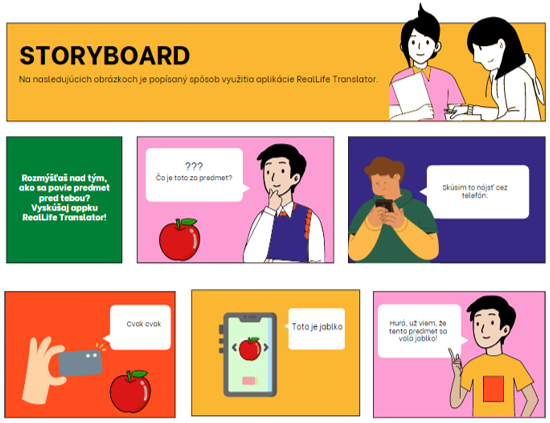

Obrázok 1: *Spôsob využitia aplikácie RealLife Translator*

## **2. Princíp aplikácie**

Navrhované riešenie pracuje za použitia 3 hlavných princípov. Tieto princípy sú uplatňované a zodpovedajú 3 hlavným fázam, na ktorých je postavené celé riešenie. Výstup z každej fáze je v už použiteľnej podobe, to znamená, že nie je nutné brať naše riešenie ako celok, ale možno ho rozkúskovať na viacero jednoduchších úloh.

Všetky nižšie uvedené modely budú implementované do prostredia mobilnej alebo počítačovej aplikácie, prostredníctvom ktorej bude celé riešenie realizované.

Na počiatku celého procesu je potrebné aby užívateľ dodal vizuálny záznam, ktorý vstupuje do prvej fáze riešenia. Tento záznam vo forme fotky alebo obrázka môže byť do aplikácie dodaný prostredníctvom importu alebo odfotografovania.

Prvý princíp, ktorý je využívaný je ***Image-to-Text***. Tento princíp je využívaný v prvej fáze, kde dochádza k identifikácii objektu z poskytnutého záznamu. 

Neskôr v druhej fáze je uplatňovaný princíp ***Translate Text***, pričom táto fáza je voliteľná. V tomto kroku má užívateľ možnosť vygenerovaný text z predošlej fáze preložiť do zvoleného jazyka.

A tretí princíp čo je ***Text-to-Speech*** je úzko spätý s treťou fázou. V tejto fáze dochádza k vysloveniu textu, či už preloženého alebo nepreloženého, na základe toho či bol zvolený preklad v predchádzajúcej fáze.

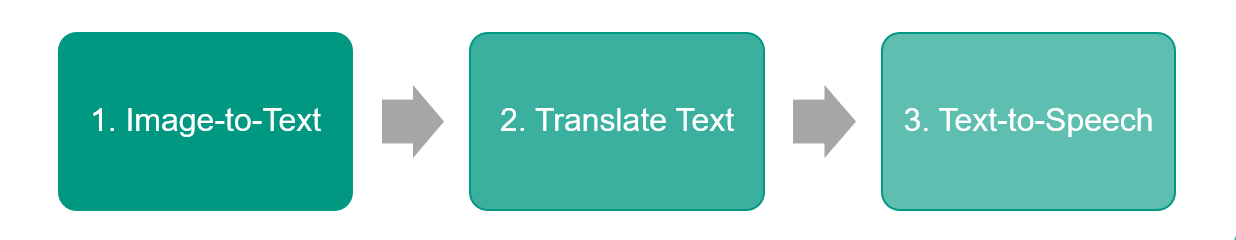

Obrázok 2: *Schéma postupnosti fází riešenia*

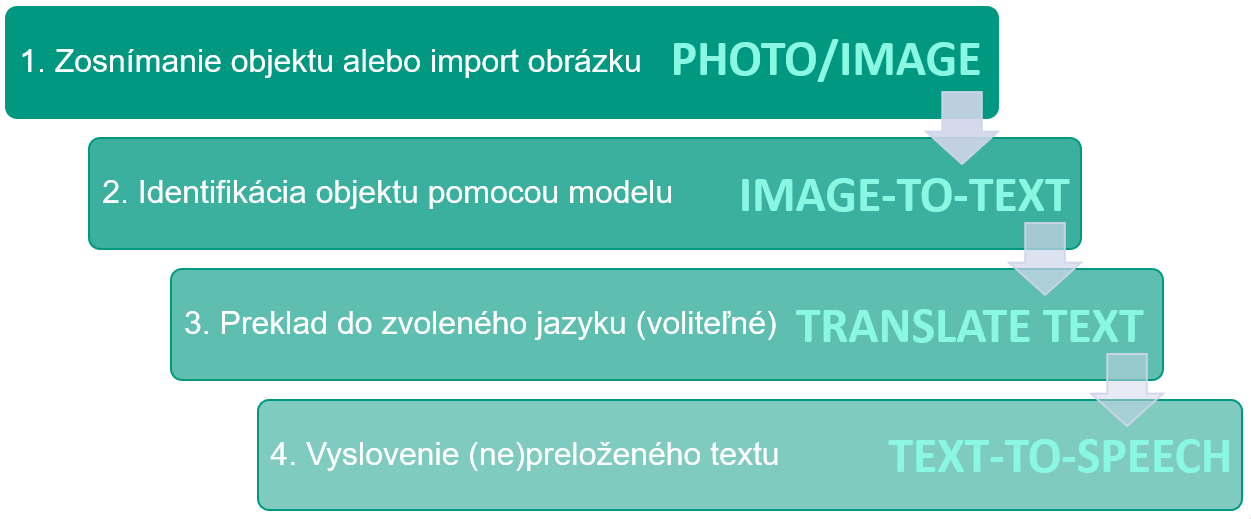

Obrázok 3: *Dekompozícia riešenia na jednoduchšie úlohy*

## **3. Technické spracovanie riešenia**

In [1]:
!pip install transformers
!pip install -q espnet==0.10.6 pyopenjtalk==0.2 pypinyin==0.44.0 parallel_wavegan==0.5.4 gdown==4.4.0 espnet_model_zoo
!pip install speechbrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **3.1 Image-to-Text**

Pomocou modelu založeného na princípe ***Image-to-Text*** je systém schopný rozpoznať objekty nachádzajúce sa na poskytnutom obrázku. Obrázok môže byť dodaný prostredníctvom importu, avšak väčší potenciál má možnosť zosnímať objekty prostredníctvom vizuálneho zariadenia ako môže byť napríklad fotoaparát mobilného telefónu, čo je dnes pokladané za súčasť vybavenia každého človeka. 

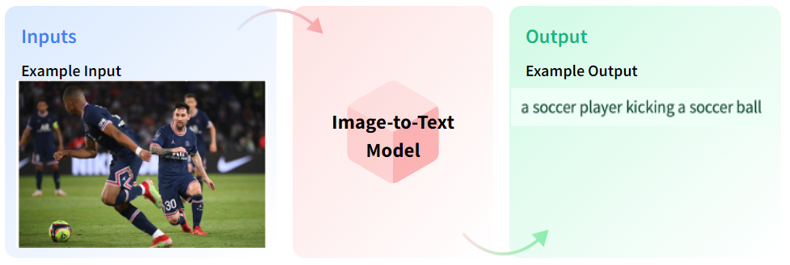

Obrázok 4: *Popis princípu Image-to-Text*

Model, za ktorého použitia bol vypracovaný proces identifikácie objektov z obrázka alebo fotografie, bol čerpaný z portálu **Hugging Face** a to konkrétne **nlpconnect/vit-gpt2-image-captioning**. Tento model je dostupný na odkaze https://huggingface.co/nlpconnect/vit-gpt2-image-captioning.

**3.1.1 Inštalácia balíčkov**

In [2]:
# import potrebných balíčkov
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch
from PIL import Image
from IPython.display import Image as ShowImage

**3.1.2 Model**

In [3]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning") # definícia atribútov modelu
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

def image_to_text(image_path): # definícia funkcie na detekciu objektov z obrázka
  images = []
  for image_path in image_path:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds

**3.1.3 Import obrázka**

In [4]:
!rm our_image.png # vymazanie obrázka

# --- input od užívateľa ---
#@markdown ## Voľba obrázka alebo fotografie, ktorá má poslúžiť na identifikáciu objektov:
image_path = "https://i.pinimg.com/564x/de/f2/7f/def27f195a219dcca31c9cf5cfdaec60.jpg" #@param {type:"string"}

!wget -O our_image.png "$image_path" # import obrázka

--2023-01-22 22:40:21--  https://i.pinimg.com/564x/de/f2/7f/def27f195a219dcca31c9cf5cfdaec60.jpg
Resolving i.pinimg.com (i.pinimg.com)... 199.232.148.84, 2a04:4e42:65::84
Connecting to i.pinimg.com (i.pinimg.com)|199.232.148.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84815 (83K) [image/jpeg]
Saving to: ‘our_image.png’

our_image.png       100%[===================>]  82.83K  --.-KB/s    in 0.005s  

2023-01-22 22:40:21 (17.2 MB/s) - ‘our_image.png’ saved [84815/84815]



**3.1.4 Output**

Identified objects: a man kicking a soccer ball on a field



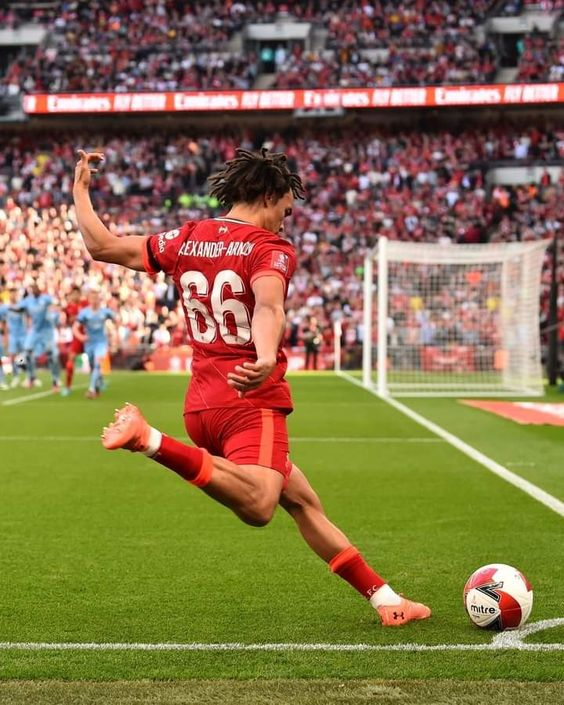

In [5]:
text = image_to_text(["our_image.png"])[0]
print("Identified objects: " + text + "\n")
ShowImage("our_image.png") # zobrazenie obrázka alebo fotografie pre kontrolu

### **3.2 Translate Text**

Pomocou modelu založeného na princípe ***Translate Text*** (Text-to-Text) systém preloží vygenerovaný text do zvoleného jazyka. Ako už bolo uvedené v kapitole 1, táto funkcia je voliteľná, to znamená, že používateľ môže s výstupom z predošlej fáze pracovať ďalej či už v jeho štandardnej nepreloženej podobe, tak aj v tej preloženej.

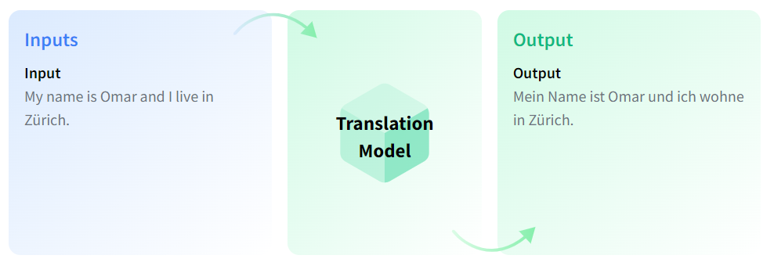

Obrázok 5: *Popis princípu Translate Text*

Pre preklad textu do zvoleného jazyka bolo taktiež ako v predošlom kroku čerpané z portálu **Hugging Face** a to konkrétne použitím modelu **t5-small**. Tento model je dostupný na odkaze https://huggingface.co/t5-small.

**3.2.1 Inštalácia balíčkov**

In [6]:
# import potrebných balíčkov
from transformers import T5ForConditionalGeneration, T5TokenizerFast as T5Tokenizer

**3.2.2 Model**

In [7]:
# definícia atribútov modelu
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

def translate_text(language): # definícia funkcie na preklad vygenerovaného textu
  if language == "English":
    return text
  else :
    input_ids = tokenizer("translate English to " + language + ": " + text, return_tensors="pt").input_ids
    outputs = model.generate(input_ids)
    translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return translation

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


**3.2.3 Voľba jazyka**

In [8]:
# --- input od užívateľa ---
#@markdown # Voľba jazyka, do ktorého má byť vygenerovaný text preložený:
language = "German" #@param ["English", "German"]

**3.2.4 Output**

In [9]:
translated_text = translate_text(language)
if language == "English":
  full_text = ("Generated text: " + translated_text)
  print(full_text)
else :
  full_text = ("Translated text: " + translated_text)
  print(full_text)

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Translated text: ein Mann, der einen Fußballball auf einem Feld kniet


### **3.3 Text-to-Speech**

Pomocou modelu založeného na princípe ***Text-to-Speech*** systém vygenerovaný text z predošlej fáze vysloví. Zvolenému jazyku sa tiež prisôsobí aj samotná výslovnosť. 

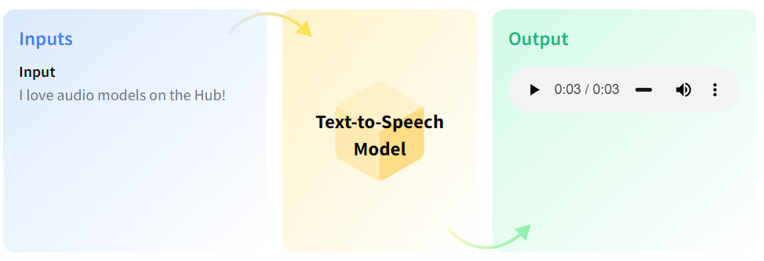

Obrázok 6: *Popis princípu Text-to-Speech*

Proces vyslovenia textu v preloženej, respektíve v nepreloženej podobe pracuje na základe modelu inšpirovaného modelmi pochádzajúcimi z portálu **Hugging Face**. Modely nesú názvy **espnet/kan-bayashi_ljspeech_vits** pre anglicky znejúcu verziu a možno ho nájsť pod odkazom https://huggingface.co/espnet/kan-bayashi_ljspeech_vits a **padmalcom/tts-tacotron2-german** pre nemecky znejúcu verziu s odkazom https://huggingface.co/padmalcom/tts-tacotron2-german.

**3.3.1 Inštalácia balíčkov**

In [10]:
# import potrebných balíčkov
from espnet2.bin.tts_inference import Text2Speech
from espnet2.utils.types import str_or_none
from IPython.display import display, Audio
import time
import torch
import torchaudio
from speechbrain.pretrained import Tacotron2
from speechbrain.pretrained import HIFIGAN

**3.3.2 Model**

In [11]:
sentence = translated_text

# --- definícia atribútov modelu - language = "English"
tag = "kan-bayashi/ljspeech_vits"
vocoder_tag = "parallel_wavegan/ljspeech_parallel_wavegan.v1"
device_test = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

text2speech = Text2Speech.from_pretrained(
    model_tag = str_or_none(tag),
    vocoder_tag = str_or_none(vocoder_tag),
    device = str(device_test),
    # Only for Tacotron 2 & Transformer
    threshold = 0.5,
    # Only for Tacotron 2
    minlenratio = 0.0,
    maxlenratio = 10.0,
    use_att_constraint = False,
    backward_window = 1,
    forward_window = 3,
    # Only for FastSpeech & FastSpeech2 & VITS
    speed_control_alpha = 1.0,
    # Only for VITS
    noise_scale = 0.333,
    noise_scale_dur = 0.333,
)

# --- model - language = "English"
sentence = translated_text
with torch.no_grad():
    start = time.time()
    wav = text2speech(sentence)["wav"]

# --- definícia atribútov modelu - language = "German"
tacotron2 = Tacotron2.from_hparams(source="padmalcom/tts-tacotron2-german", savedir = "tmpdir_tts") # Intialize TTS (tacotron2)
hifi_gan = HIFIGAN.from_hparams(source="speechbrain/tts-hifigan-ljspeech", savedir = "tmpdir_vocoder") # Intialize Vocoder (HiFIGAN)

# --- model - language = "German"
mel_output, mel_length, alignment = tacotron2.encode_text(sentence) # Running the TTS
waveforms = hifi_gan.decode_batch(mel_output) # Running Vocoder (spectrogram-to-waveform)
audio = torchaudio.save('example_TTS.wav',waveforms.squeeze(1), 22050) # Save the waverform

/usr/local/lib/python3.8/dist-packages/espnet2/gan_tts/vits/monotonic_align/__init__.py:21: UserWarning: Cython version is not available. Fallback to 'EXPERIMETAL' numba version. If you want to use the cython version, please build it as follows: `cd espnet2/gan_tts/vits/monotonic_align; python setup.py build_ext --inplace`
  warnings.warn(


**3.3.3 Output**

In [12]:
print(full_text + "\n")
if language == "English":
  display(Audio(wav.view(-1).cpu().numpy(), rate=text2speech.fs))
else :
  display(Audio('example_TTS.wav'))

Translated text: ein Mann, der einen Fußballball auf einem Feld kniet

